crop the image to square

In [93]:
# import dependencies
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from utils import make_square_image
from PIL import Image
from rembg import remove
import numpy as np
import io


# display paratmeters for matplotlib
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [94]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

## Original Preprocessing Code


In [95]:
# # Helper function to preprocess the image so that it can be inputted in MobileNetV2
# def preprocess(image):
#   image = tf.cast(image, tf.float32)
#   image = tf.image.resize(image, (224, 224))
#   image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
#   image = image[None, ...]
#   return image

# # Helper function to extract labels from probability vector
# def get_imagenet_label(probs):
#   return decode_predictions(probs, top=1)[0][0]

## New Preprocessing Code


In [153]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224), method=tf.image.ResizeMethod.AREA)
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

# Helper function to remove the background from an image tensor
def remove_background(image, background_color=(255, 255, 255)):
    """
    Removes the background from a TensorFlow image tensor, crops to a square bounding box,
    and replaces the background with a specified color.

    Args:
        image (tf.Tensor): Input image tensor.
        background_color (tuple): RGB color for the new background (default is white).

    Returns:
        tf.Tensor: Image tensor with the background removed, cropped, and replaced with the specified color.
    """
    # Step 1: Convert the TensorFlow tensor to a PIL image
    image_np = image.numpy()  # Convert TensorFlow tensor to NumPy array
    pil_image = Image.fromarray(image_np)

    # Step 2: Remove the background using rembg
    img_bytes = io.BytesIO()
    pil_image.save(img_bytes, format="PNG")  # Save the PIL image to a bytes buffer
    input_image = img_bytes.getvalue()  # Get the image bytes
    output_image = remove(input_image)  # Remove the background

    # Step 3: Convert the output bytes back to a PIL image
    pil_image_no_bg = Image.open(io.BytesIO(output_image)).convert("RGBA")

    # Step 4: Crop to the bounding box
    # Get the bounding box of the alpha channel
    bbox = pil_image_no_bg.getchannel("A").getbbox()
    if bbox:
        pil_image_no_bg = pil_image_no_bg.crop(bbox)
    else:
        raise ValueError("No bounding box found. The image might be fully transparent.")

    # Step 5: Add the new background color
    # Determine the size of the square canvas (longest side of the bounding box)
    width, height = pil_image_no_bg.size
    square_size = max(width, height)

    # Create a new square image with the specified background color
    background = Image.new("RGBA", (square_size, square_size), background_color + (255,))

    # Calculate the position to paste the cropped image (centered)
    paste_position = ((square_size - width) // 2,
                      (square_size - height) // 2)

    # Paste the cropped image onto the new background
    background.paste(pil_image_no_bg, paste_position, pil_image_no_bg.getchannel("A"))

    # Convert the image to RGB (to remove transparency)
    combined_image = background.convert("RGB")

    # Step 6: Convert the PIL image back to a TensorFlow tensor
    image = tf.convert_to_tensor(np.array(combined_image), dtype=tf.uint8)

    return image

## Original image
Let's use a sample image of a [Labrador Retriever](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg) by Mirko [CC-BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/) from Wikimedia Common and create adversarial examples from it. The first step is to preprocess it so that it can be fed as an input to the MobileNetV2 model.

In [197]:
# Set the image path to a local file
image_path = "images/lamp_post.jpg"  # Replace with the actual path to your image

# Read the image file
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

# Remove background and preprocess the image
image = remove_background(image)

# Preprocess the image
image = preprocess(image)

# Predict using the pretrained model
image_probs = pretrained_model.predict(image)

# Get the numeric index of the predicted class (0–999)
imagenet_index = tf.argmax(image_probs[0]).numpy()  # Find the index of the maximum probability

# Decode the predictions to get the class label and confidence
decoded_predictions = tf.keras.applications.mobilenet_v2.decode_predictions(image_probs, top=1)
top_prediction = decoded_predictions[0][0]  # Get the top prediction

# Extract the label and confidence
label = top_prediction[1]  # Class label
confidence = top_prediction[2]  # Confidence score

# Output the results
print(f"ImageNet Index: {imagenet_index}")
print(f"Class Label: {label}")
print(f"Confidence: {confidence * 100:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
ImageNet Index: 733
Class Label: pole
Confidence: 44.42%


Let's have a look at the image.


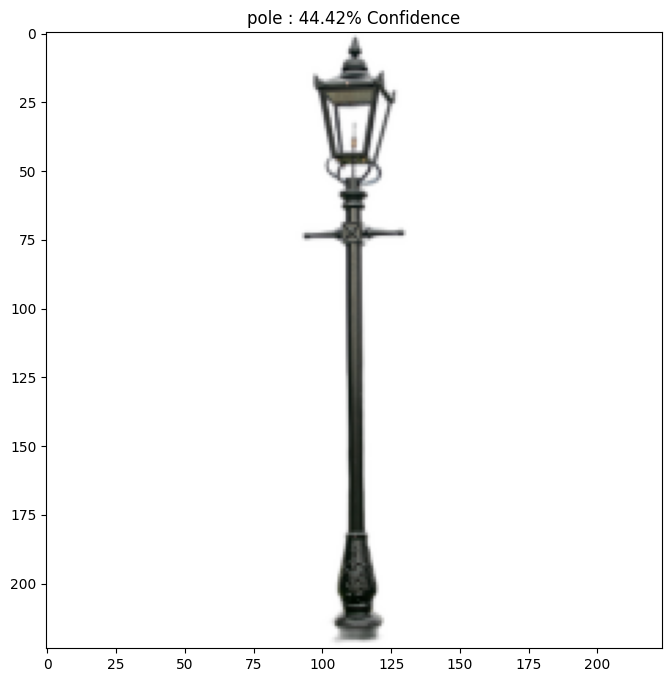

In [198]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1] for mpl display
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Create the adversarial image

### Implementing fast gradient sign method
The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. As mentioned, for this task, the gradients are taken with respect to the image.

In [199]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

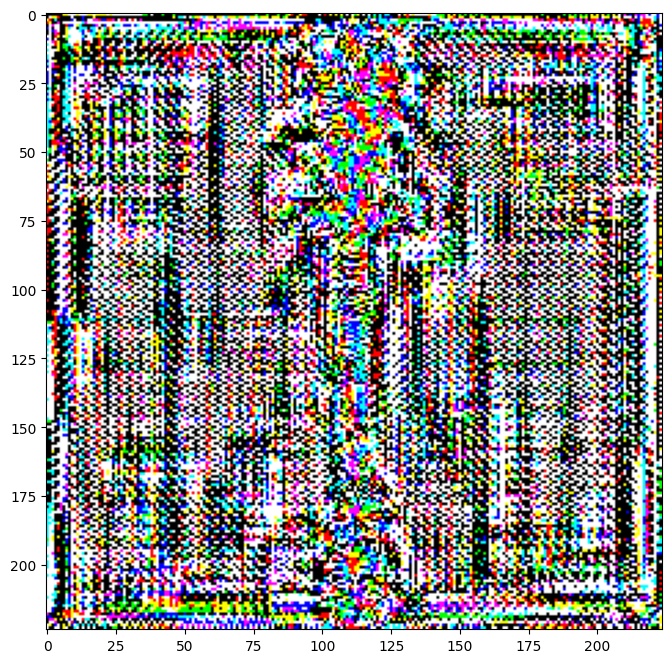

In [201]:
# Visualize the perturbations
# Get the input label of the image.
image_index = imagenet_index # Needs to be the index of the class you want to attack
label = tf.one_hot(image_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

Let's try this out for different values of epsilon and observe the resultant image. You'll notice that as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.

In [202]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


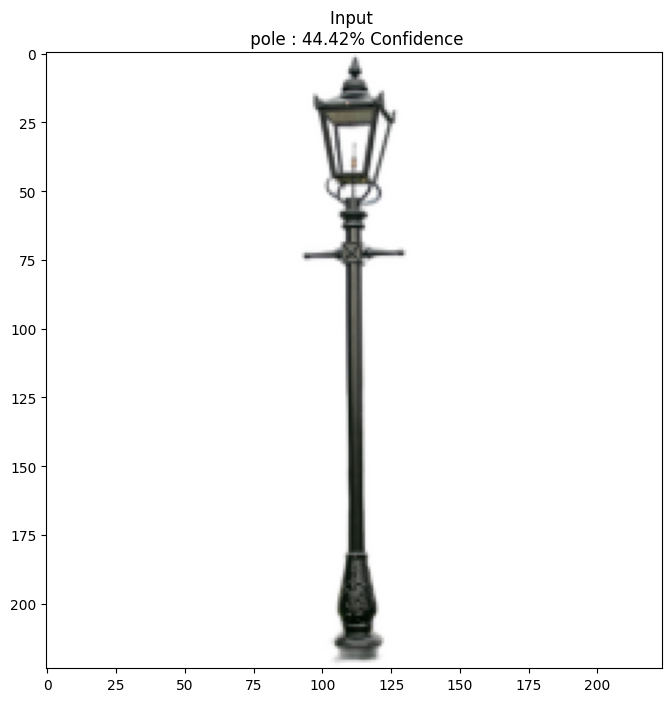

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


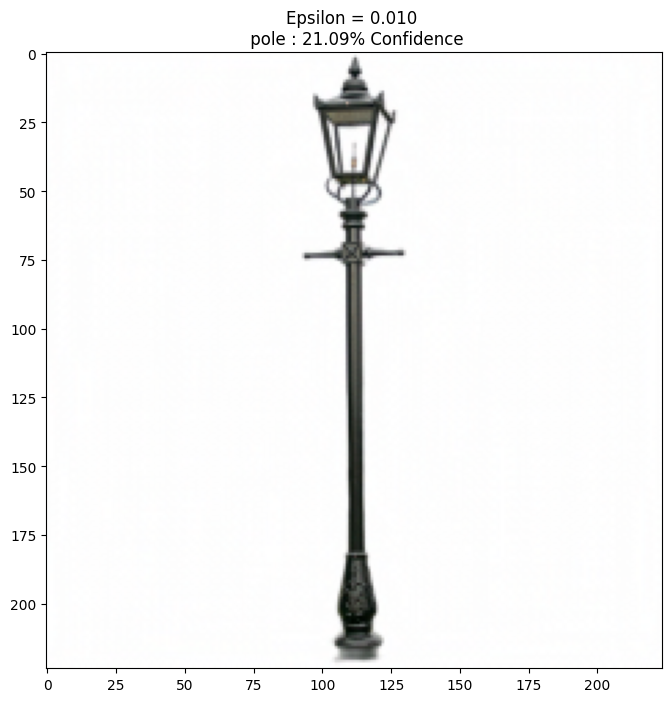

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


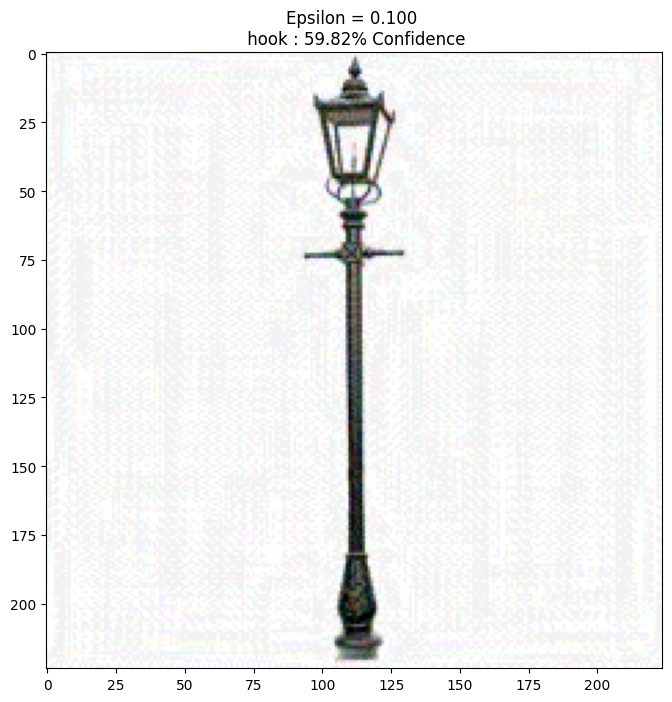

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


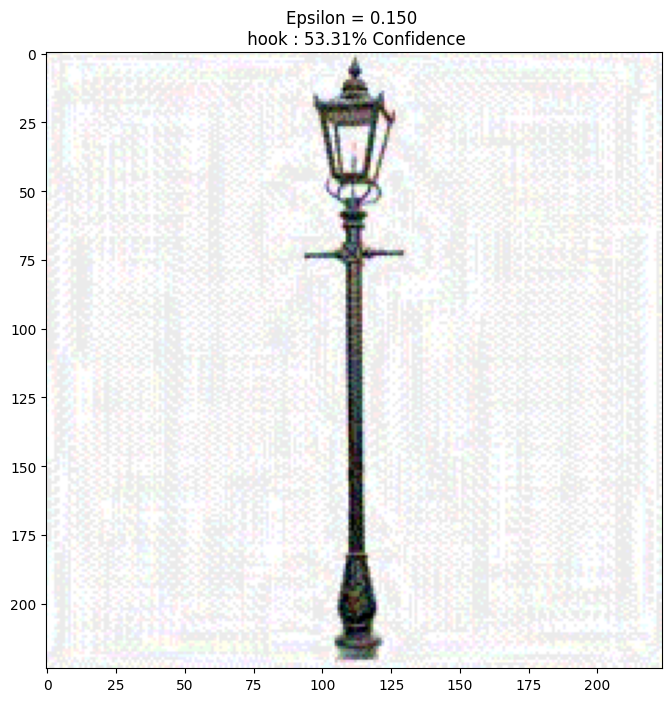

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


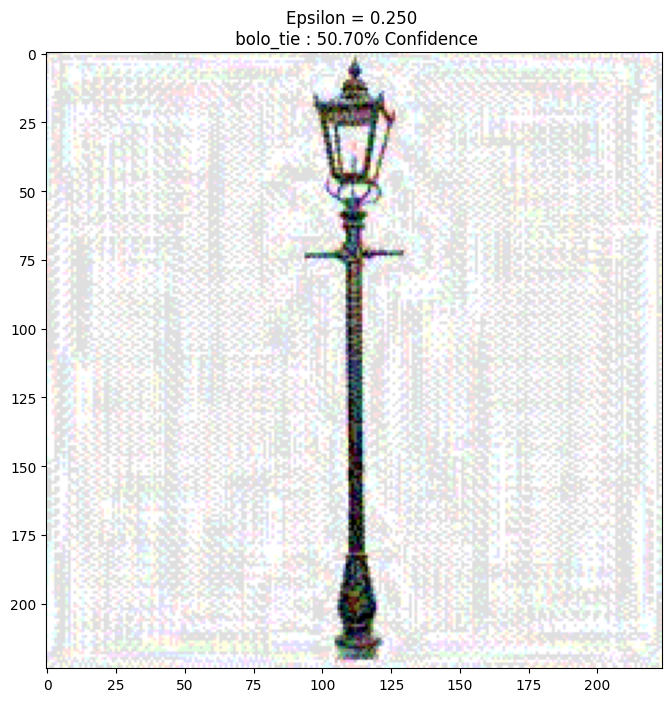

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


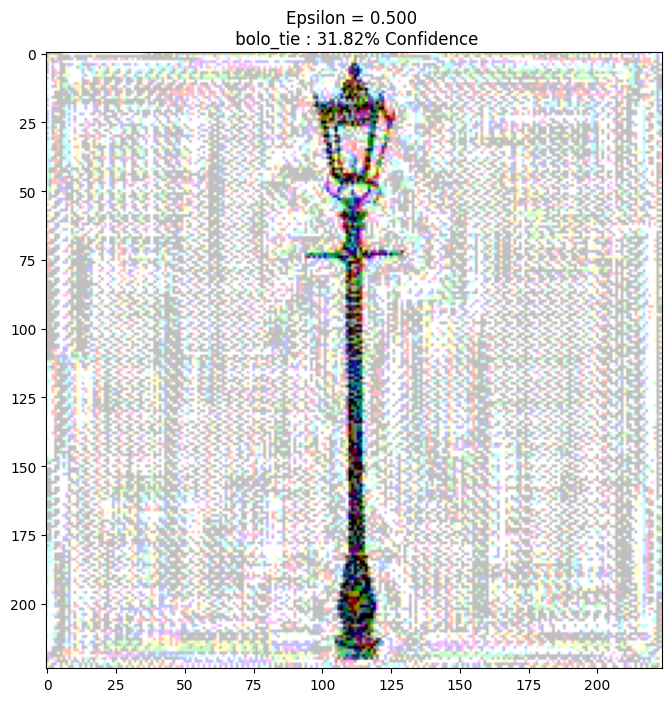

In [203]:
epsilons = [0, 0.01, 0.1, 0.15, 0.25, 0.5]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])